# Прогнозирование ряда со сложной сезонностью

## Подготовка

Естественно, в первую очередь подключим необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pylab as plt
import seaborn
import warnings
import gc
import calendar
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

Для начала загрузим ранее полученные отфильтрованные данные и посмотрим на них. А затем выберем какую-нибудь ячейку

In [2]:
filtered_regions = pd.read_csv("../filtered_data.csv")
print filtered_regions.head()

   region_id     count  mean_count  log_count       west       east  \
0       1075   49699.0   66.799731   4.696356 -74.022246 -74.011135   
1       1076  102870.0  138.266129   5.012293 -74.022246 -74.011135   
2       1077   64581.0   86.802419   4.810111 -74.022246 -74.011135   
3       1125   49135.0   66.041667   4.691400 -74.011135 -74.000023   
4       1126  135328.0  181.892473   5.131391 -74.011135 -74.000023   

       north      south  center_lat  center_long  
0  40.705825  40.697437   40.701631   -74.016691  
1  40.714213  40.705825   40.710019   -74.016691  
2  40.722601  40.714213   40.718407   -74.016691  
3  40.705825  40.697437   40.701631   -74.005579  
4  40.714213  40.705825   40.710019   -74.005579  


In [3]:
filtered_regions['count'].mean()

112490.03921568628

Выберем, например, ячейку с номером 1125

In [4]:
region_id = 1125

## Считывание данных и обработка данных

Считаем сырые данные из файлов, обработаем их и запишем в новую таблицу. С данной таблицей в дальнейшем и будем работать.

In [5]:
files = [
    'D:/Course 6 data/yellow_tripdata_2015-11.csv',
    'D:/Course 6 data/yellow_tripdata_2015-12.csv',
    'D:/Course 6 data/yellow_tripdata_2016-01.csv',
    'D:/Course 6 data/yellow_tripdata_2016-02.csv',
    'D:/Course 6 data/yellow_tripdata_2016-03.csv',
    'D:/Course 6 data/yellow_tripdata_2016-04.csv',
    'D:/Course 6 data/yellow_tripdata_2016-05.csv',
    'D:/Course 6 data/yellow_tripdata_2016-06.csv'
]

In [6]:
ny_west, ny_east, ny_south, ny_north = -74.25559, -73.70001, 40.49612, 40.91553

Отфильтруем некорректные поездки, например, с числом пассажиров равном нулю.

In [7]:
def verify_df(df):
    df.drop(df.index[df['passenger_count'] == 0], inplace=True)
    df.drop(df.index[df['trip_distance'] == 0.0], inplace=True)
    df.drop(df.index[df['tpep_pickup_datetime'] == df['tpep_dropoff_datetime']], inplace=True)
    gc.collect()
    df.drop(df.index[(df['pickup_longitude'] < ny_west) |
                    (df['pickup_longitude'] > ny_east) |
                    (df['pickup_latitude'] < ny_south) |
                    (df['pickup_latitude'] > ny_north)])
    df.drop(['tpep_dropoff_datetime', 'passenger_count', 'trip_distance'], axis=1, inplace=True)
    gc.collect()
    return df

Отфильтруем регионы, которые неиспользуются в данном задании

In [8]:
def filter_other_regions(df, region):
    a = df['pickup_longitude'] < region['west'].values()[0]
    b = df['pickup_longitude'] > region['east'].values()[0]
    c = df['pickup_latitude'] < region['south'].values()[0]
    d = df['pickup_latitude'] > region['north'].values()[0]
    df.drop(df.index[a | b | c | d], inplace=True)
    return df

И наконец сгруппируем данные по дате начала поездки

In [9]:
def group_by_pickuptime(df, month_dates):
    df['pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'].str[:-6], format='%Y-%m-%d %H')
    series = df.groupby(['pickup_datetime'])['pickup_datetime'].count().rename('count')
    df = pd.DataFrame(index=month_dates)
    df['count'] = series
    df.fillna(0, inplace=True)
    df['pickup_datetime'] = month_dates
    df = df[['pickup_datetime', 'count']]
    return df

Для каждого файла будем генерировать даты начала и конца месяца. Это необходимо, т.к. во время группировки данных могут оказаться пробелы. Собственно, чтобы этих пробелов не было индексом будет набор сгенерированных дат.

In [10]:
def get_month_dates(file_name):
    year = file_name[-11:-7]
    month = file_name[-6:-4]
    if month[0] == '0':
        month_last_day = calendar.monthrange(int(year), int(month[1]))[1]
    else:
        month_last_day = calendar.monthrange(int(year), int(month))[1]
    month_begin = year + "-" + month + "-01"
    month_end = year + "-" + month + "-" + str(month_last_day)
    return pd.date_range(month_begin, month_end + " 23:00:00", freq='1H')

Соберем все в цикл по всем файлам. gc.collect() позволяет удалять неиспользуемые данные, что очень помогает при обработке больших данных. Потенциально в текущем задании можно использовать данные за несколько лет без каких-либо проблем.

Считывать будем только необходимые столбцы. Затем будем производить последовательные преобразования. И в конце обработки добавим полученные данные в целевую таблицу - result_data.

In [11]:
%%time
data = ''
result_data = pd.DataFrame()
gc.collect()
region_data = pd.Series(filtered_regions[filtered_regions['region_id'] == region_id].to_dict())
for file_path in files:
    print file_path
    data = pd.read_csv(file_path, usecols=['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count',
                                                'trip_distance', 'pickup_longitude', 'pickup_latitude'])
    print data.shape
    data = verify_df(data)
    print data.shape
    data = filter_other_regions(data, region_data)
    print data.shape
    data = group_by_pickuptime(data, get_month_dates(file_path))
    print data.shape
    result_data = result_data.append(data, ignore_index=True)
    data = ''
    gc.collect()

D:/Course 6 data/yellow_tripdata_2015-11.csv
(11312676, 6)
(11238883, 3)
(44205, 3)
(720, 2)
D:/Course 6 data/yellow_tripdata_2015-12.csv
(11460573, 6)
(11386270, 3)
(46707, 3)
(744, 2)
D:/Course 6 data/yellow_tripdata_2016-01.csv
(10906858, 6)
(10842267, 3)
(43002, 3)
(744, 2)
D:/Course 6 data/yellow_tripdata_2016-02.csv
(11382049, 6)
(11313880, 3)
(46896, 3)
(696, 2)
D:/Course 6 data/yellow_tripdata_2016-03.csv
(12210952, 6)
(12139293, 3)
(52159, 3)
(744, 2)
D:/Course 6 data/yellow_tripdata_2016-04.csv
(11934338, 6)
(11856068, 3)
(49567, 3)
(720, 2)
D:/Course 6 data/yellow_tripdata_2016-05.csv
(11836853, 6)
(11763422, 3)
(49135, 3)
(744, 2)
D:/Course 6 data/yellow_tripdata_2016-06.csv
(11135470, 6)
(11064250, 3)
(48702, 3)
(720, 2)
Wall time: 3min 52s


Закэшируем данные в файл дабы каждый раз не производить считывание и обработку данных.

In [12]:
print result_data.head()
print result_data.shape
print result_data.info()
result_data.to_csv("result_data.csv")

      pickup_datetime  count
0 2015-11-01 00:00:00  108.0
1 2015-11-01 01:00:00  173.0
2 2015-11-01 02:00:00   57.0
3 2015-11-01 03:00:00   30.0
4 2015-11-01 04:00:00   20.0
(5832, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5832 entries, 0 to 5831
Data columns (total 2 columns):
pickup_datetime    5832 non-null datetime64[ns]
count              5832 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 91.2 KB
None


Считываем данные и убеждаемся, что все ок

In [11]:
result_data = pd.read_csv('result_data.csv', usecols=['pickup_datetime', 'count'], parse_dates=['pickup_datetime'])
print result_data.head()
print result_data.shape

      pickup_datetime  count
0 2015-11-01 00:00:00  108.0
1 2015-11-01 01:00:00  173.0
2 2015-11-01 02:00:00   57.0
3 2015-11-01 03:00:00   30.0
4 2015-11-01 04:00:00   20.0
(5832, 2)


Теперь нарисуем график исходных данных за все время, включая июнь 2016. В дальнейшем мы вырежем его из выборки.

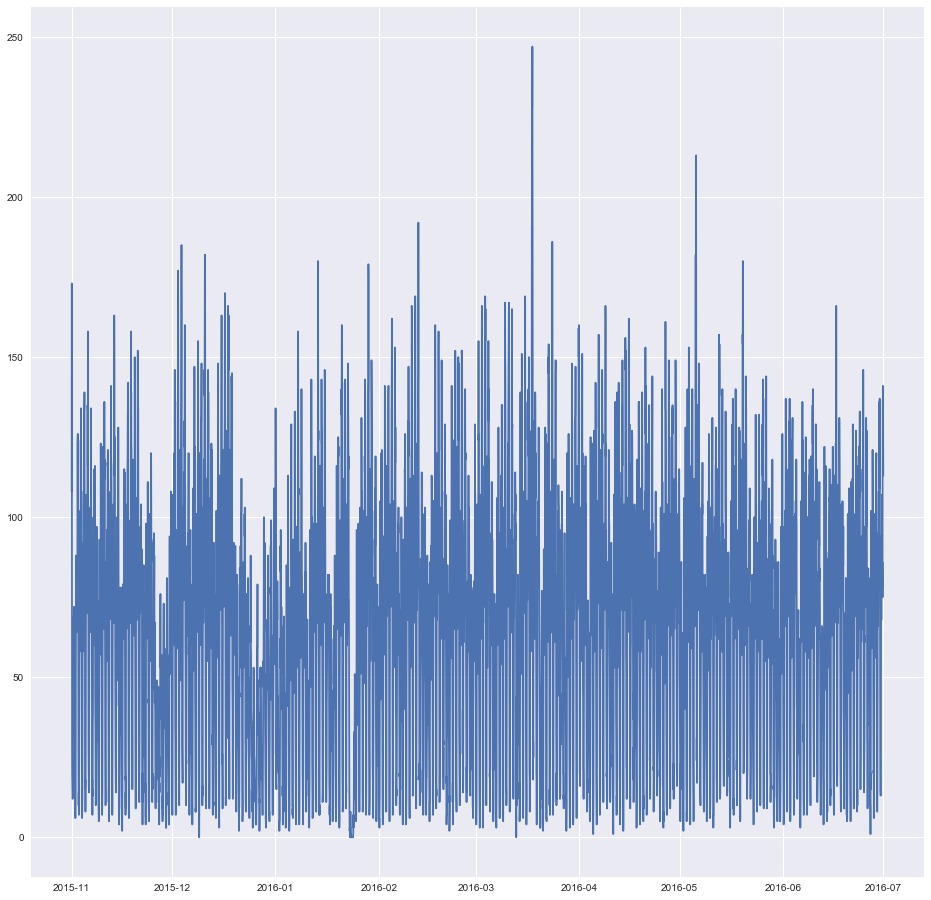

In [14]:
plt.figure(figsize=(16,16))
plt.plot(result_data['pickup_datetime'], result_data['count'])
plt.show()

Отделяем июнь 2016 года

In [26]:
all_data = result_data.copy()
result_data = result_data[result_data['pickup_datetime'] < '2016-06-01']

Убедимся, что июнь пропал из данных:

In [27]:
print result_data.iloc[-5:]

         pickup_datetime  count
5107 2016-05-31 19:00:00   88.0
5108 2016-05-31 20:00:00   65.0
5109 2016-05-31 21:00:00   78.0
5110 2016-05-31 22:00:00   94.0
5111 2016-05-31 23:00:00   53.0


## Подготавливаем модель

В первую очередь подберем значение гиперпараметра K. Делать это будем следующим образом: добавим в данные регресионные признаки, обучим простейшую линейную регресионную модель и посчитаем RMSE. Среди всех таких моделей выберем ту (и соответственно K), которое значимо улучшает качество предсказаний, но при этом не использует слишком много дополнительных признаков. 

In [28]:
k = 25
T = result_data.shape[0]
data = ''
data = result_data.copy()
print result_data.head()

      pickup_datetime  count
0 2015-11-01 00:00:00  108.0
1 2015-11-01 01:00:00  173.0
2 2015-11-01 02:00:00   57.0
3 2015-11-01 03:00:00   30.0
4 2015-11-01 04:00:00   20.0


In [29]:
data = result_data.copy()
results = []
best_aic = float("inf")
for i in range(1, k + 1):
    data["s_" + str(i)] = np.sin(np.array(range(1, T + 1)) * 2. * np.pi * float(i) / 168.)
    data["c_" + str(i)] = np.cos(np.array(range(1, T + 1)) * 2. * np.pi * float(i) / 168.)
    
    columns = data.columns[2:]
    X = pd.DataFrame(data, columns=columns)
    y = data['count']
    model = LinearRegression(n_jobs=-1)
    model.fit(X, y)
    y_pred = model.predict(X)
    rmse = mean_squared_error(y, y_pred)
    results.append(rmse)

И нарисуем график получившихся ошибок.

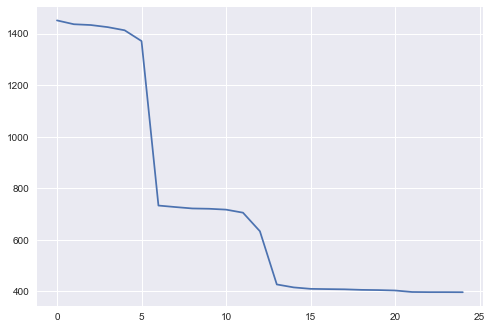

In [30]:
plt.plot(results)
plt.show()

Отсюда видно, что оптимальное значение K находится от 6 до 10. Возьмем, например, К = 7. И для него составим регресионные признаки

In [31]:
data = result_data.copy()
k = 7
for i in range(1, k + 1):
    data["s_" + str(i)] = np.sin(np.array(range(1, T + 1)) * 2. * np.pi * float(i) / 168.)
    data["c_" + str(i)] = np.cos(np.array(range(1, T + 1)) * 2. * np.pi * float(i) / 168.)
print data.head()
print data.shape

      pickup_datetime  count       s_1       c_1       s_2       c_2  \
0 2015-11-01 00:00:00  108.0  0.037391  0.999301  0.074730  0.997204   
1 2015-11-01 01:00:00  173.0  0.074730  0.997204  0.149042  0.988831   
2 2015-11-01 02:00:00   57.0  0.111964  0.993712  0.222521  0.974928   
3 2015-11-01 03:00:00   30.0  0.149042  0.988831  0.294755  0.955573   
4 2015-11-01 04:00:00   20.0  0.185912  0.982566  0.365341  0.930874   

        s_3       c_3       s_4       c_4       s_5       c_5       s_6  \
0  0.111964  0.993712  0.149042  0.988831  0.185912  0.982566  0.222521   
1  0.222521  0.974928  0.294755  0.955573  0.365341  0.930874  0.433884   
2  0.330279  0.943883  0.433884  0.900969  0.532032  0.846724  0.623490   
3  0.433884  0.900969  0.563320  0.826239  0.680173  0.733052  0.781831   
4  0.532032  0.846724  0.680173  0.733052  0.804598  0.593820  0.900969   

        c_6       s_7       c_7  
0  0.974928  0.258819  0.965926  
1  0.900969  0.500000  0.866025  
2  0.781831  0

## Анализ остатков

Обучим модель и получим остатки.

In [32]:
columns = data.columns[2:]
X = pd.DataFrame(data, columns=columns)
y = data['count']
model = LinearRegression(n_jobs=-1)
model.fit(X, y)
prediction = model.predict(X)
r = pd.DataFrame(data=(y - prediction).values, index=data['pickup_datetime'], columns=['predicted_count'])
print r.head()

                     predicted_count
pickup_datetime                     
2015-11-01 00:00:00        53.632058
2015-11-01 01:00:00       126.302995
2015-11-01 02:00:00        17.185026
2015-11-01 03:00:00        -4.145820
2015-11-01 04:00:00       -10.015302


И нарисуем график остатков

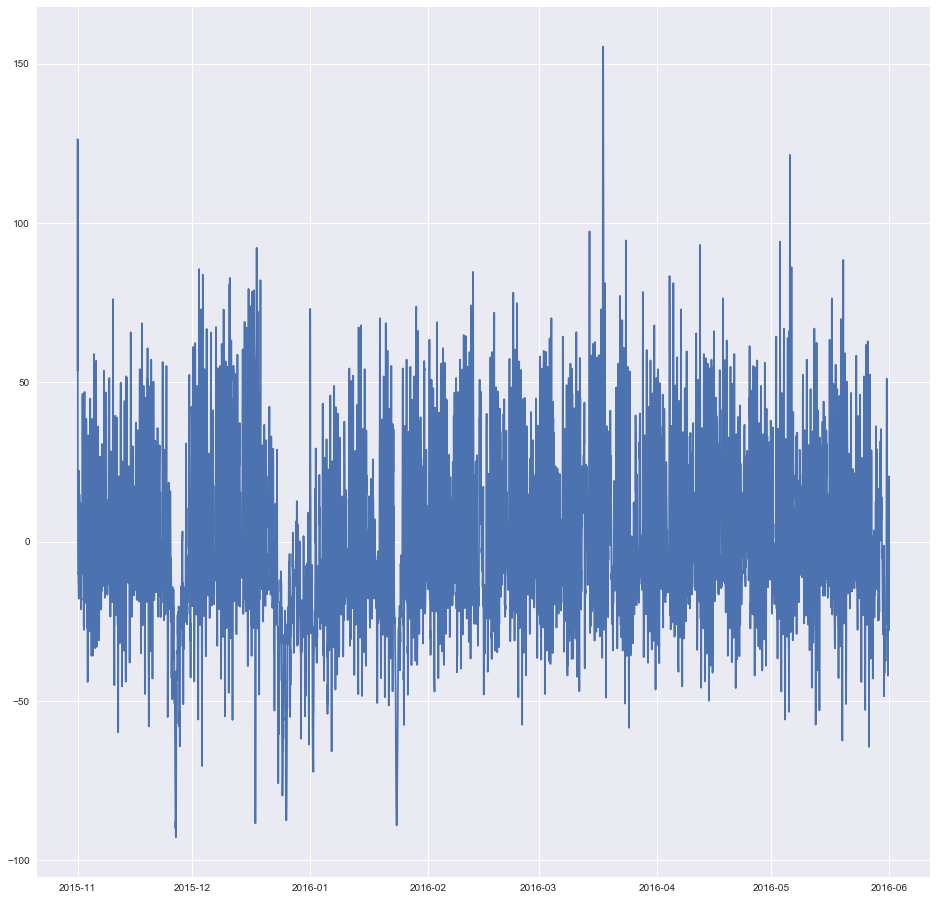

In [33]:
plt.figure(figsize=(16,16))
plt.plot(r)
plt.show()

Видно, что ряд является нестационарным. Для надежности проведем STL-декомпозицию ряда остатков.

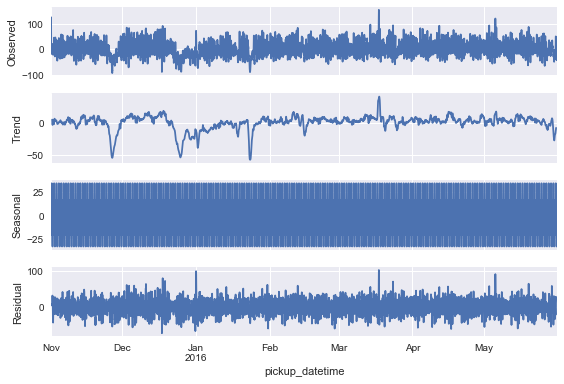

In [34]:
plt.figure(figsize=(16,8))
sm.tsa.seasonal_decompose(r['predicted_count']).plot()
plt.show()

По графику тренда явно видно, что ряд остатков не является стационарным. Поэтому нужно дифференцировать их.

Сначала уберем суточную зависимость.

In [35]:
r['diff24'] = r['predicted_count'] - r['predicted_count'].shift(24)

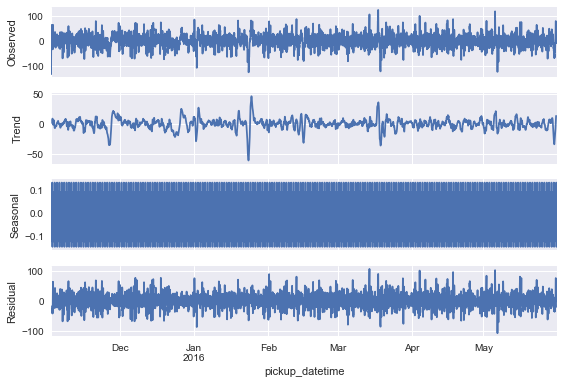

In [36]:
plt.figure(figsize=(16,16))
sm.tsa.seasonal_decompose(r['diff24'][24:]).plot()
plt.show()

Уже лучше, но видны довольно большие скачки в тренде. Давайте проведем обычное дифференцирование.

In [37]:
r['diff24_1'] = r['diff24'] - r['diff24'].shift(1)

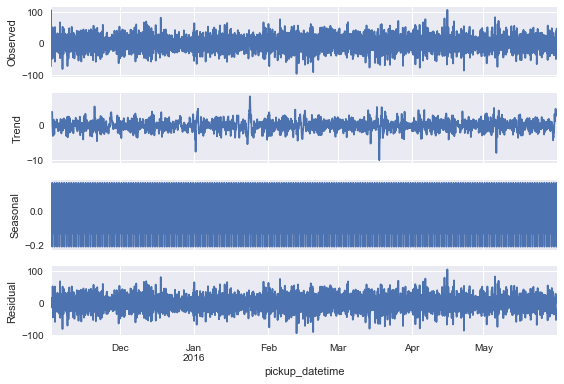

In [38]:
plt.figure(figsize=(16,16))
sm.tsa.seasonal_decompose(r['diff24_1'][25:]).plot()
plt.show()

И еще раз.

In [39]:
r['diff24_2'] = r['diff24_1'] - r['diff24_1'].shift(1)

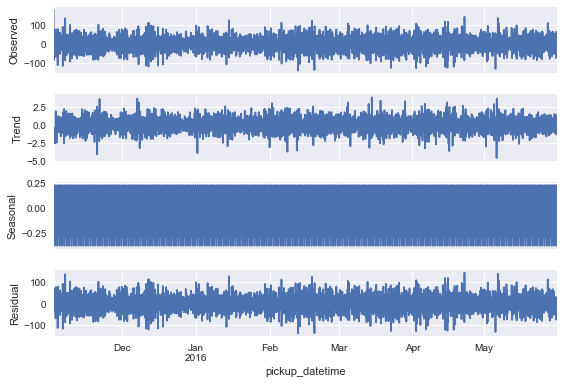

In [40]:
plt.figure(figsize=(16,16))
sm.tsa.seasonal_decompose(r['diff24_2'][26:]).plot()
plt.show()

Теперь STL-декомпозия ряда выглядит соответствующей стационарному ряду.

### Подбор гиперпараметров

Для подбора начальных приближений гиперпараметров P, p, Q, q построим графики ACF и PACF полученного ранее ряда.

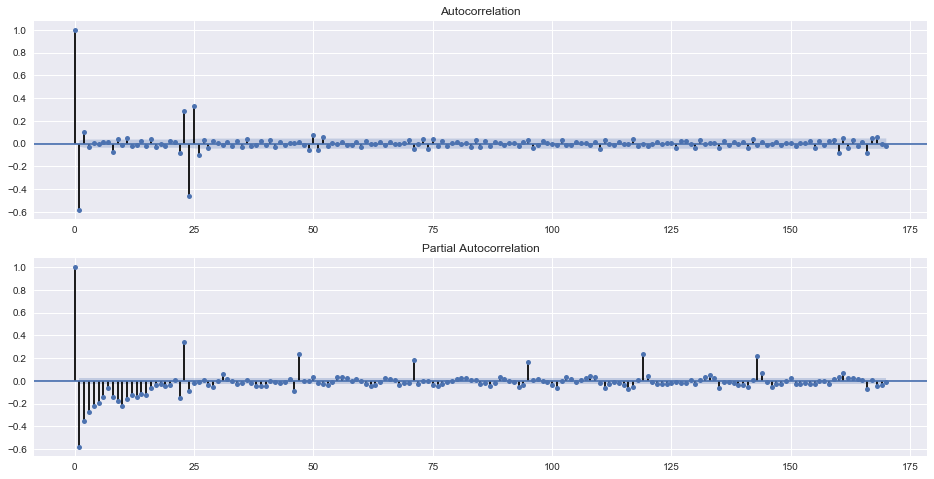

In [41]:
plt.figure(figsize=(16,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(r['diff24_2'][26:], lags=170, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(r['diff24_2'][26:], lags=170, ax=ax)
plt.show()

Получили следующие начальные значения гиперпараметров: D = 1, d = 2, Q = 1, q = 2, P = 0, p = 20. Модель обучается очень долго поэтому подбирать гиперпараметры будем на апреле 2016. А затем обучим модель на всех данных. Опытным путем выяснено, что это не ухудшает итоговое качество модели. Так же сократим p до 5 в угоду производительности. Как будет показано далее, получившиеся параметры достаточно эффективно решают задачу.

In [59]:
D = 1
d = 2
Q = 1
q = 2
P = 0
p = 5

In [60]:
Qs = range(0, Q + 1)
qs = range(0, q + 1)
Ps = range(0, P + 1)
ps = range(0, p + 1)
Ds = range(0, D + 1)
ds = range(0, d + 1)

In [61]:
from itertools import product
parameters = list(product(ps, ds, qs, Ps, Ds, Qs))
print len(parameters)

216


Выделим данные за апрель 2016

In [53]:
april_data = data[(data['pickup_datetime'] >= '2016-04-01') & (data['pickup_datetime'] < '2016-05-01')]
print april_data['pickup_datetime'].head()
print april_data.iloc[-5:]['pickup_datetime']

3648   2016-04-01 00:00:00
3649   2016-04-01 01:00:00
3650   2016-04-01 02:00:00
3651   2016-04-01 03:00:00
3652   2016-04-01 04:00:00
Name: pickup_datetime, dtype: datetime64[ns]
4363   2016-04-30 19:00:00
4364   2016-04-30 20:00:00
4365   2016-04-30 21:00:00
4366   2016-04-30 22:00:00
4367   2016-04-30 23:00:00
Name: pickup_datetime, dtype: datetime64[ns]


In [54]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(april_data['count'].values, exog=april_data[columns], 
                                        order=(param[0], param[1], param[2]), 
                                        seasonal_order=(param[3], param[4], param[5], 24)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    except BaseException as e:
        print 'LinAlgError', param
        continue
    aic = model.aic
    print aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
#warnings.filterwarnings('default')

('wrong parameters:', (0, 0, 0, 0, 0, 0))
7575.93298778
('wrong parameters:', (0, 0, 0, 0, 1, 0))
2894442.37888
7521.8504425
7087.52075059
129104.905121
3138991.47673
nan
nan
213332.631041
1277240.16316
('wrong parameters:', (0, 1, 0, 0, 0, 0))
6333.67953772
('wrong parameters:', (0, 1, 0, 0, 1, 0))
414791.384865
6457.49931683
6325.339921
279280.955927
664266.058701
6449.30144458
6212.34373212
527660.415626
768046.757285
('wrong parameters:', (0, 2, 0, 0, 0, 0))
6883.88633972
('wrong parameters:', (0, 2, 0, 0, 1, 0))
774016.869854
6456.16391763
6334.18384183
449889.607188
968769.18415
6459.29004316
6337.38173216
nan
nan
6453.59627538
6323.33630287
24213.11124
90826.665199
6455.17306753
6319.98380239
140266.127119
2973748.41541
6452.23444397
6254.92138937
266016.742975
2601581.92821
6457.49941292
6327.50990628
234326.305037
699097.426902
('wrong parameters:', (1, 1, 1, 0, 0, 0))
('wrong parameters:', (1, 1, 1, 0, 0, 1))
25396.2871606
440573.334866
('wrong parameters:', (1, 1, 2, 0, 0, 0

Получив оптимальные значения гиперпараметров, можно теперь обучить модель на всех данных.

In [55]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  720
Model:             SARIMAX(5, 1, 1)x(0, 0, 1, 24)   Log Likelihood               -3027.138
Date:                            Sun, 16 Apr 2017   AIC                           6098.276
Time:                                    17:30:11   BIC                           6199.020
Sample:                                01-01-1970   HQIC                          6137.169
                                     - 01-01-1970                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
s_1          -10.3274      1.479     -6.984      0.000     -13.226      -7.429
c_1           -7.4395      1.604     -4.637      0.000     -10.584      -4.295
s_2           -4.8392      1.192     -4.061      0.000      -7.175      -2.504
c_2           -1.5906      1.211     -1.314      0.189      -3.964       0.783
s_3           -3.0276      0.905     -3.345      0.001      -4.801      -1.254
c_3            0.7567      0.859      0.881      0.379      -0.927       2.441
s_4            0.4613      0.872      0.529      0.597      -1.247       2.169
c_4            4.5369      0.938      4.836      0.000       2.698       6.376
s_5            3.1992      1.273      2.514      0.012       0.705       5.693
c_5            5.6309      1.350      4.170      0.000       2.985       8.277
s_6            7.5065      1.842      4.074      0.000       3.895      11.117
c_6            6.3015      1.601      3.937      0.000       3.164       9.439
s_7          -38.8168      1.920    -20.217      0.000     -42.580     -35.054
c_7           -5.3196      2.140     -2.485      0.013      -9.515      -1.125
ar.L1          0.5684      0.035     16.083      0.000       0.499       0.638
ar.L2         -0.0477      0.039     -1.238      0.216      -0.123       0.028
ar.L3         -0.0861      0.046     -1.885      0.059      -0.176       0.003
ar.L4         -0.0501      0.047     -1.057      0.291      -0.143       0.043
ar.L5         -0.1754      0.039     -4.454      0.000      -0.253      -0.098
ma.L1         -0.9976      0.011    -91.090      0.000      -1.019      -0.976
ma.S.L24       0.3580      0.036      9.983      0.000       0.288       0.428
sigma2       262.1151     11.905     22.017      0.000     238.781     285.449
===================================================================================
Ljung-Box (Q):                      186.64   Jarque-Bera (JB):                70.45
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                             0.43
Prob(H) (two-sided):                  0.09   Kurtosis:                         4.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [62]:
best_model = sm.tsa.statespace.SARIMAX(data['count'].values, exog=data[columns], order=(5, 1, 1), 
                                        seasonal_order=(0, 0, 1, 24)).fit(disp=-1)

## Анализ результатов

Первое что приходит в голову - нарисовать предсказание модели поверх данных, на которых проводилось обучение. Это и сделаем.

Отрисуем данные за май 2016

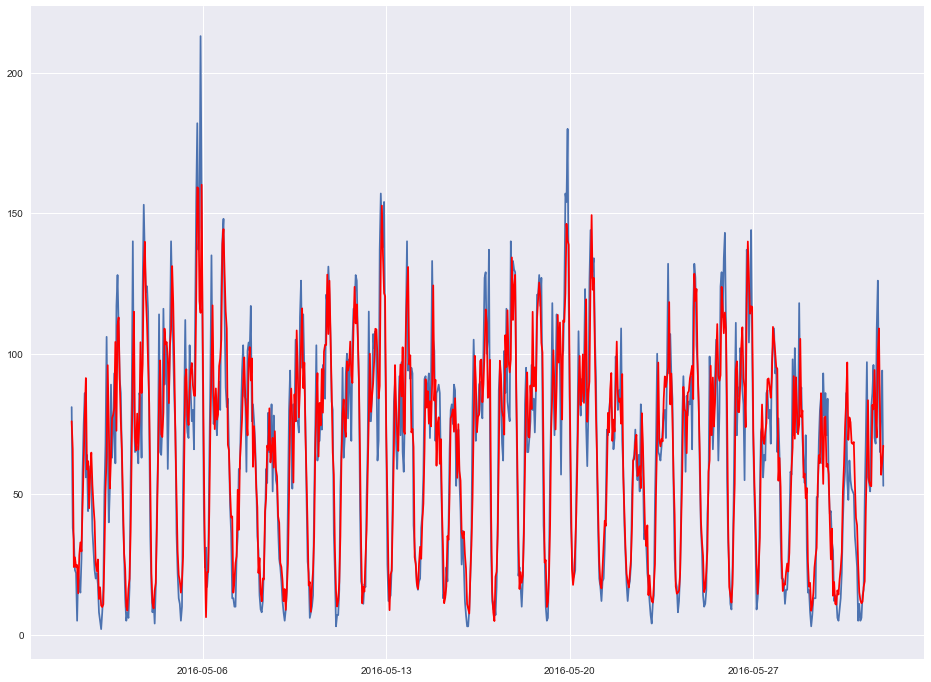

In [63]:
plt.figure(figsize=(16,12))
dates = data.iloc[-744:]['pickup_datetime']
plt.plot(dates, data.iloc[-744:]['count'])
plt.plot(dates, best_model.fittedvalues.iloc[-744:], color='r')
plt.show()

Чтобы получше разглядеть посмотрим на последние 3 дня

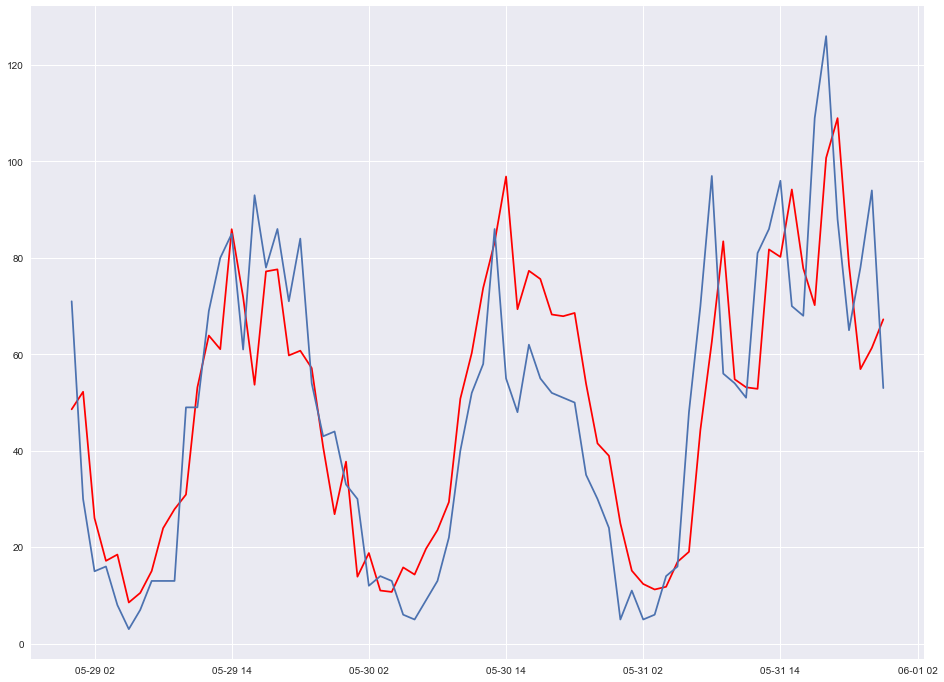

In [64]:
plt.figure(figsize=(16,12))
dates = data.iloc[-72:]['pickup_datetime']
plt.plot(dates, best_model.fittedvalues.iloc[-72:], color='r')
plt.plot(dates, data.iloc[-72:]['count'])
plt.show()

Как можно увидеть, предсказания весьма точно следуют изменениями внутри дня. Из недостатков можно отметить, что модель недостаточно уверенно "дожимает" значения до реальных. Возможно, увеличение количества данных или более полный перебор дадут более лучшие результаты.

Теперь посмотрим на остатки. Проверим являются ли они "белым шумом".

Нарисуем для начала остатки. Вроде похоже на "белый шум", но убедимся наверняка.

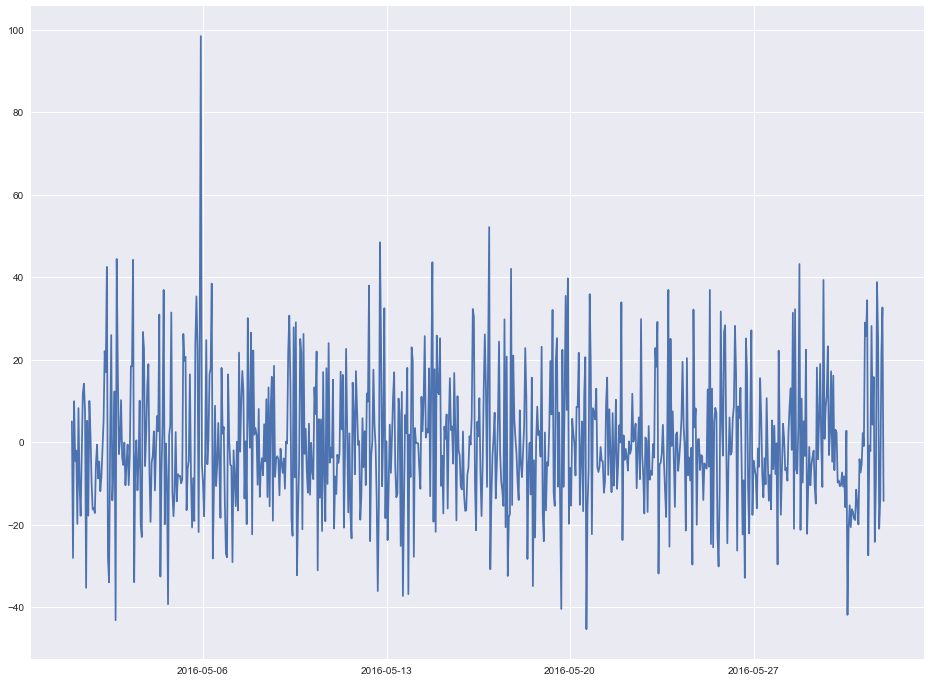

In [68]:
plt.figure(figsize=(16,12))
plt.plot(data.iloc[-744:]['pickup_datetime'], best_model.resid[-744:])
plt.show()

In [69]:
sm.tsa.stattools.adfuller(best_model.resid[-744:])[1]

2.1382085096488815e-11

Критерий Дики-Фуллера уверенно отвергает гипотезу о нестационарности ряда остатков. Есть пара просадок, которые говорят о какой-то неучтенности, но в целом все хорошо.

## Предсказание значений за июнь

In [162]:
from datetime import timedelta

In [178]:
exog = pd.DataFrame()
st = data.shape[0]
cnt = 24
date_start = pd.to_datetime('2016-06-01')
date_end = pd.to_datetime('2016-06-01') + timedelta(hours=cnt)
for i in range(1, k + 1):
    exog["s_" + str(i)] = np.sin(np.array(range(st, st + cnt)) * 2. * np.pi * float(i) / 168.)
    exog["c_" + str(i)] = np.cos(np.array(range(st, st + cnt)) * 2. * np.pi * float(i) / 168.)

In [179]:
june = best_model.predict(st, st + cnt - 1, exog=exog, dynamic=True).values

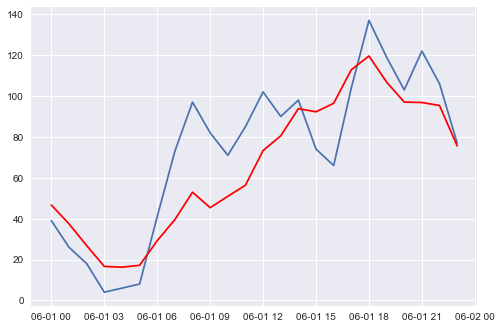

In [180]:
june_data = all_data[(all_data['pickup_datetime'] >= date_start) & 
                     (all_data['pickup_datetime'] < date_end)]
plt.plot(june_data['pickup_datetime'], june_data['count'])
plt.plot(june_data['pickup_datetime'], june, color='r')
plt.show()

## Выводы

Как видно из графиков выше, модель хуже всего описывает обеденное время ~12-14 часов. Со всем остальным модель справляется неплохо. Например, модель хорошо отражает направление тренда. Особо закономерностей я не увидел. Увеличить качество модели можно увеличив объем данных, тем самым добавив годовую сезонность и за счет более полного перебора параметров модели.